⚠️ No GPU found, training on CPU.
Found 1510 images belonging to 2 classes.
Found 377 images belonging to 2 classes.


C:\Users\Aravind\anaconda3\envs\cap2\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 379s 7s/step - accuracy: 0.6248 - loss: 4.9819 - val_accuracy: 0.7480 - val_loss: 4.7671
Epoch 2/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 370s 7s/step - accuracy: 0.8351 - loss: 4.4894 - val_accuracy: 0.7401 - val_loss: 4.4963
Epoch 3/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 384s 7s/step - accuracy: 0.8398 - loss: 4.1752 - val_accuracy: 0.7639 - val_loss: 4.1484
Epoch 4/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 383s 7s/step - accuracy: 0.8810 - loss: 3.8500 - val_accuracy: 0.7878 - val_loss: 3.8998
Epoch 5/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 390s 7s/step - accuracy: 0.8872 - loss: 3.5803 - val_accuracy: 0.7347 - val_loss: 3.7350
Epoch 6/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 354s 7s/step - accuracy: 0.8893 - loss: 3.3278 - val_accuracy: 0.7798 - val_loss: 3.4373
Epoch 7/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 378s 7s/step - accuracy: 0.9165 - loss: 3.1042 - val_accuracy: 0.7878 - val_loss: 3.2076
Epoch 8/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 381s 7s/step - accuracy: 0.9289 - loss: 2.8830 - val_accuracy: 0.7745 - v

ValueError: x and y must have same first dimension, but have shapes (1,) and (20,)

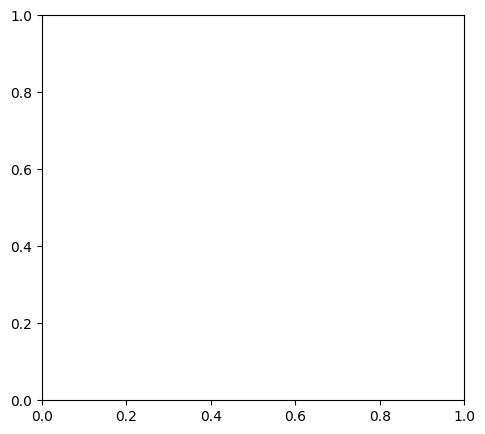

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.regularizers import l2
from sklearn.utils.class_weight import compute_class_weight
from PIL import Image

# ✅ Enable GPU (CUDA) Acceleration
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("✅ Using GPU for training!")
else:
    print("⚠️ No GPU found, training on CPU.")

# ✅ Define dataset paths
train_dataset_path = r"C:\Users\Aravind\Downloads\cap2\the_wildfire_dataset_2n_version\train"
val_dataset_path = r"C:\Users\Aravind\Downloads\cap2\the_wildfire_dataset_2n_version\val"
test_dataset_path = r"C:\Users\Aravind\Downloads\cap2\the_wildfire_dataset_2n_version\test"

# ✅ Define Image Parameters
IMG_SIZE = (224, 224)  
BATCH_SIZE = 32  

# ✅ Optimized Data Augmentation (Balanced Transformations)
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,   
    width_shift_range=0.1,  
    height_shift_range=0.1,  
    shear_range=0.1,  
    zoom_range=0.15,  
    horizontal_flip=True,
    brightness_range=[0.9, 1.1],  
    validation_split=0.2  
)

# ✅ Load Training Data
train_data = datagen.flow_from_directory(
    train_dataset_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    subset="training"
)

# ✅ Load Validation Data
val_data = datagen.flow_from_directory(
    train_dataset_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    subset="validation"
)

# ✅ Compute Class Weights with Normalization
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_data.classes),
    y=train_data.classes
)
class_weight_dict = {i: class_weights[i] / max(class_weights) for i in range(len(class_weights))}  # ✅ Normalize

# ✅ Load Pre-trained ResNet50V2 (Allow Partial Training)
base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers[:-10]:  # ✅ Keep last 10 layers trainable
    layer.trainable = False

# ✅ Define the Optimized CNN Model
with tf.device('/GPU:0'):  # ✅ Force training on GPU
    x = base_model.output
    x = GlobalAveragePooling2D()(x)  
    x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)  
    x = Dropout(0.4)(x)  # ✅ Reduced dropout to prevent underfitting
    output = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=output)

# ✅ Compile the Model with Optimized Learning Rate
model.compile(optimizer=Adam(learning_rate=0.00005),  # ✅ Adjusted LR for fine-tuning
              loss='binary_crossentropy',
              metrics=['accuracy'])

# ✅ Callbacks for Best Model Saving & Early Stopping
EPOCHS = 20  
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint("wildfire_detection_model.keras", save_best_only=True, monitor='val_loss')

# ✅ Train the Model with Class Weights
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=EPOCHS,
    class_weight=class_weight_dict,  
    callbacks=[early_stopping, checkpoint]
)

# ✅ Save the Final Model
model.save("wildfire_detection_model_final.keras")

# ✅ Plot Training Results
def plot_training(history):
    acc = history.history.get('accuracy', [])
    val_acc = history.history.get('val_accuracy', [])
    loss = history.history.get('loss', [])
    val_loss = history.history.get('val_loss', [])
    
    epochs = range(len(acc))
    
    plt.figure(figsize=(12, 5))
    
    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1])
    plt.legend()
    plt.title('Training vs Validation Accuracy')

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bs-', label='Training Loss')
    plt.plot(epochs, val_loss, 'rs-', label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training vs Validation Loss')

    plt.show()

# ✅ Display Training Graphs
plot_training(history)

# ✅ Evaluate Model on Test Data
test_datagen = ImageDataGenerator(rescale=1./255)  
test_data = test_datagen.flow_from_directory(
    test_dataset_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=False
)

test_loss, test_acc = model.evaluate(test_data)
print(f"🔥 Test Accuracy: {test_acc * 100:.2f}%")
print(f"📉 Test Loss: {test_loss:.4f}")


In [5]:
print(f"Accuracy length: {len(history.history.get('accuracy', []))}")
print(f"Validation Accuracy length: {len(history.history.get('val_accuracy', []))}")
print(f"Loss length: {len(history.history.get('loss', []))}")
print(f"Validation Loss length: {len(history.history.get('val_loss', []))}")


Accuracy length: 20
Validation Accuracy length: 20
Loss length: 20
Validation Loss length: 20


In [10]:
import matplotlib.pyplot as plt
import numpy as np

def plot_training(history):
    acc = np.array(history.history.get('accuracy', []))
    val_acc = np.array(history.history.get('val_accuracy', []))
    loss = np.array(history.history.get('loss', []))
    val_loss = np.array(history.history.get('val_loss', []))

    epochs = np.arange(1, len(acc) + 1)  # Ensure epochs align correctly
    
    plt.figure(figsize=(12, 5))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1])
    plt.legend()
    plt.title('Training vs Validation Accuracy')

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bs-', label='Training Loss')
    plt.plot(epochs, val_loss, 'rs-', label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training vs Validation Loss')

    plt.show()


In [11]:
import numpy as np

acc = np.array(history.history.get('accuracy', []))
val_acc = np.array(history.history.get('val_accuracy', []))
loss = np.array(history.history.get('loss', []))
val_loss = np.array(history.history.get('val_loss', []))

epochs = np.arange(1, len(acc) + 1)

print("Epochs:", epochs)
print("Training Accuracy:", acc)
print("Validation Accuracy:", val_acc)
print("Training Loss:", loss)
print("Validation Loss:", val_loss)


Epochs: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
Training Accuracy: [0.70198673 0.8331126  0.86423838 0.87748343 0.89271522 0.89801323
 0.92119205 0.92715234 0.94172186 0.94105959 0.93576157 0.94304633
 0.94172186 0.95629138 0.96887416 0.9615894  0.96622515 0.97218543
 0.96688741 0.97549671]
Validation Accuracy: [0.74801064 0.74005306 0.76392573 0.7877984  0.73474801 0.77984083
 0.7877984  0.77453583 0.74270558 0.74801064 0.7771883  0.7877984
 0.73209548 0.78514588 0.7241379  0.7877984  0.75331563 0.77188331
 0.7877984  0.77188331]
Training Loss: [4.83597183 4.41532326 4.08890724 3.78788114 3.51913857 3.27323842
 3.04758906 2.83783603 2.6411376  2.46373391 2.30616522 2.15660906
 2.02253556 1.88416922 1.75729942 1.65247178 1.55286241 1.45612168
 1.37475479 1.28591394]
Validation Loss: [4.7670846  4.49629593 4.14835024 3.89979219 3.73499274 3.43732381
 3.20756817 3.10817242 3.03202605 2.82427645 2.66309977 2.49535894
 2.4642086  2.23451352 2.35483265 2.14277577 2.066

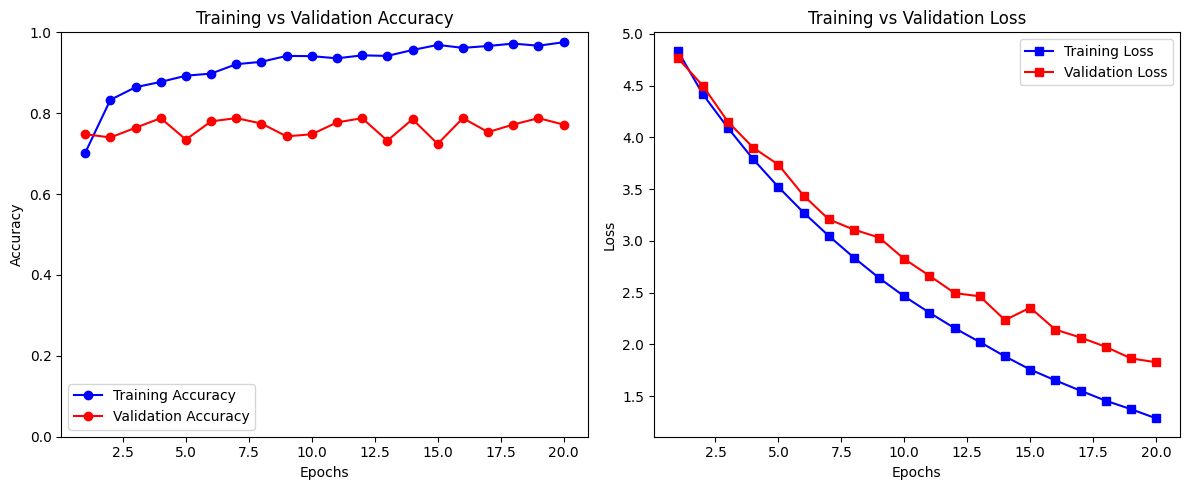

In [12]:
import matplotlib.pyplot as plt
import numpy as np

def plot_training(history):
    acc = np.array(history.history.get('accuracy', []))
    val_acc = np.array(history.history.get('val_accuracy', []))
    loss = np.array(history.history.get('loss', []))
    val_loss = np.array(history.history.get('val_loss', []))

    if len(acc) == 0 or len(loss) == 0:
        print("⚠️ No training data available to plot.")
        return

    epochs = np.arange(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1])
    plt.legend()
    plt.title('Training vs Validation Accuracy')

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bs-', label='Training Loss')
    plt.plot(epochs, val_loss, 'rs-', label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training vs Validation Loss')

    plt.tight_layout()  # Prevent overlapping of subplots
    plt.show(block=True)  # Ensure the plot is displayed

# ✅ Run the function again
plot_training(history)


In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

test_datagen = ImageDataGenerator(rescale=1.0 / 255)  

test_data = test_datagen.flow_from_directory(
    test_dataset_path,    # Ensure this path is correct
    target_size=IMG_SIZE, # Use the same size as training images
    batch_size=BATCH_SIZE,
    class_mode="binary",  # Change to "categorical" if you have multiple classes
    shuffle=False
)


Found 410 images belonging to 2 classes.


In [14]:
test_loss, test_acc = model.evaluate(test_data)

print(f"🔥 Test Accuracy: {test_acc * 100:.2f}%")
print(f"📉 Test Loss: {test_loss:.4f}")


13/13 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.9081 - loss: 1.4922
🔥 Test Accuracy: 91.95%
📉 Test Loss: 1.4405


In [15]:
import numpy as np

predictions = model.predict(test_data)  # Get predictions
predicted_classes = np.round(predictions).astype(int)  # Convert probabilities to class labels

# Get true labels from test_data
true_labels = test_data.classes

# Print first 10 results for checking
for i in range(10):
    print(f"Actual: {true_labels[i]}, Predicted: {predicted_classes[i]}")


13/13 ━━━━━━━━━━━━━━━━━━━━ 36s 3s/step
Actual: 0, Predicted: [0]
Actual: 0, Predicted: [0]
Actual: 0, Predicted: [0]
Actual: 0, Predicted: [0]
Actual: 0, Predicted: [0]
Actual: 0, Predicted: [0]
Actual: 0, Predicted: [0]
Actual: 0, Predicted: [0]
Actual: 0, Predicted: [0]
Actual: 0, Predicted: [0]


C:\Users\Aravind\AppData\Local\Temp\ipykernel_3080\1559253719.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred_label = class_labels[int(predicted_classes[i])]


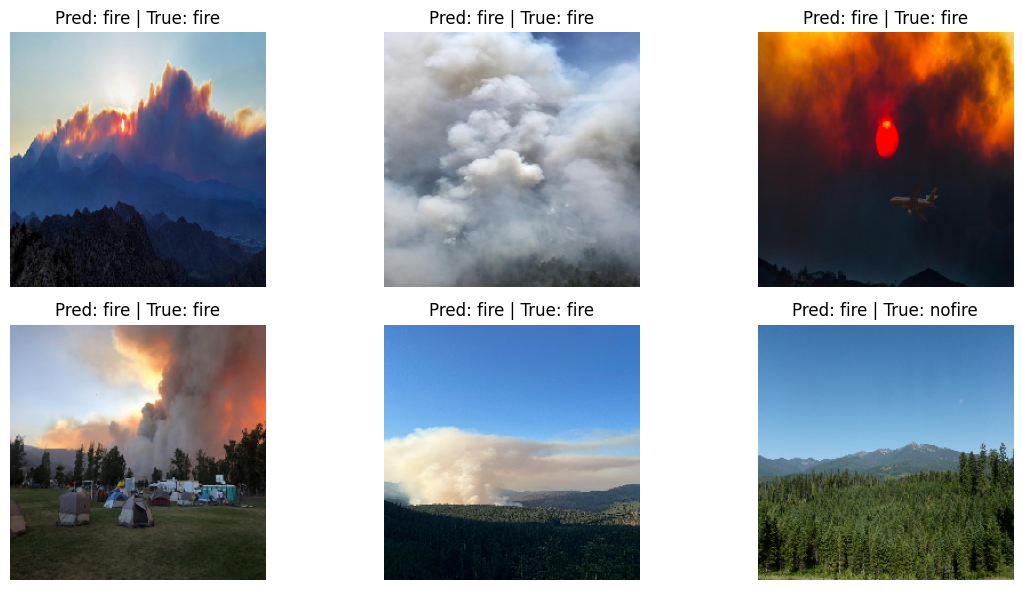

In [17]:
import matplotlib.pyplot as plt

# Get class labels
class_labels = list(test_data.class_indices.keys())

# Plot some test images with their predictions
plt.figure(figsize=(12, 6))

for i in range(6):
    img, label = test_data[i]  # Get batch of images from test generator
    plt.subplot(2, 3, i + 1)
    plt.imshow(img[0])  # Show the first image in batch

    # Ensure indexing works correctly
    pred_label = class_labels[int(predicted_classes[i])]
    true_label = class_labels[int(label[0])]

    plt.title(f"Pred: {pred_label} | True: {true_label}")
    plt.axis("off")

plt.tight_layout()
plt.show()

